# **LNG3120 - Classification de documents**
Catégorisation de textes basée sur des vecteurs de scores TF-IDF

Lareau, F. (2017). « Classification de documents », *LNG3120 - Traitement automatique du langage*. Département
de linguistique et de traduction, Université de Montréal.

In [125]:
import nltk, re, random
from math import log
from matplotlib import pyplot as plt
import numpy as np
from nltk.tokenize import RegexpTokenizer

# token: str, document: [str] -> float
def tf(token, document):
    return nltk.FreqDist(document)[token]/ (len(document))

# token: str, corpus: [[str]] -> float
def idf(token, corpus):
    return log((len(corpus) / ( 1 + (len([d[1] for d in corpus if token in d])))))

# token: str, document: [str], corpus: [[str]] -> float
def tf_idf(token, document, idfs):
    return tf(token, document) * idfs[token]

tokenizer = RegexpTokenizer(r"\w+")

Importer les données

In [112]:
# Importer les données (fichiers .txt)
import os

acteur = 'ophq'
def lire_corpus(acteur):
    path = '/Users/camilledemers/Documents/03-corpus/2-data/1-fr/'

    corpus =  [] 

    # Change the directory
    os.chdir(path)

    for file in os.listdir()[:75]: # les 75 premières pages seulement 
        if file.endswith(".txt"):
          file_path = path + file
        
        with open(file_path, 'r', encoding = "UTF-8") as f:
            data = f.readlines()
            corpus.append(data[1].lower().strip('\n'))

    return corpus

Prétraitement

In [113]:
corpus = [tokenizer.tokenize(t) for t in lire_corpus(acteur)]

FreqDist d'une page du site du site (30 tokens les plus fréquents):


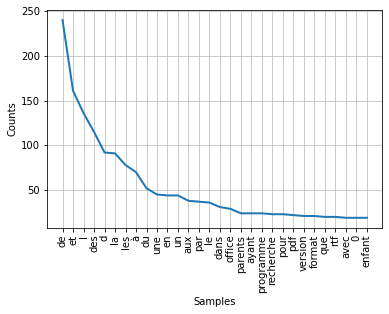

<AxesSubplot:xlabel='Samples', ylabel='Counts'>

In [114]:
fd_acteur = [nltk.FreqDist(d) for d in corpus]

print("FreqDist d'une page du site du site (30 tokens les plus fréquents):")
random.choice(fd_acteur).plot(30)

On extrait ensuite le vocabulaire de tout le corpus (MF et MSSS combinés).

In [115]:
fd = nltk.FreqDist()
for f in fd_acteur:
    fd.update(f)

vocabulaire = fd.keys()
N = fd.N()
print(N, 'tokens dans le corpus.')
print('Vocabulaire de', len(vocabulaire), 'formes uniques.')

129542 tokens dans le corpus.
Vocabulaire de 6018 formes uniques.


In [116]:
# Importer l'antidictionnaire pour filtrer les données
from pandas import *

# Stopwords fréquents en français
path = "/Users/camilledemers/Documents/04-filtrage/stopwords.csv"
with open(path, 'r', encoding="utf-8") as f:
    stopwords = read_csv(f)
    stopwords = [t.lower() for t in stopwords['Stopwords'].tolist()]


# Stopwords fréquents en anglais
path = '/Users/camilledemers/Documents/04-filtrage/stop_words_english.txt'
with open(path, 'r', encoding="utf-8") as f:
    sw = [w.strip('\n').lower() for w in f.readlines()]

stopwords += sw

# Signes de ponctuation
import string 
punct = [s for s in string.punctuation] 
punct += ['»' ,'©', '']

stopwords += punct

In [117]:
# token: str, fd: FreqDist -> boolean
def utile(token, fd):
    minlen = 2
    minfreq = 3
    return token not in stopwords and len(token)>=minlen and not re.search('^\d+$', token) and fd[token]>=minfreq


# vocabulaire: [str], fd: FreqDist -> [str]
def utiles(vocabulaire, fd):
    return [t for t in vocabulaire if utile(t, fd)]

In [118]:
dimensions = utiles(vocabulaire, fd)
print('Nous allons construire des vecteurs à', len(dimensions), 'dimensions')

print('Voici les 200 premières dimensions (selon leur ordre d\'apparition dans le corpus) : ')
print(dimensions[:200])

Nous allons construire des vecteurs à 2317 dimensions
Voici les 200 premières dimensions (selon leur ordre d'apparition dans le corpus) : 
['lancement', 'plan', 'action', 'interministériel', 'politique', 'gouvernementale', 'prévention', 'santé', 'office', 'handicapées', 'québec', 'besoin', 'aide', 'aller', 'express', 'principal', 'champ', 'recherche', 'ouvrir', 'joindre', 'services', 'directs', 'population', 'programmes', 'mesures', 'partenariat', 'subventions', 'soutien', 'organismes', 'promotion', 'expérimentation', 'études', 'analyses', 'rapports', 'financés', 'guides', 'cyberbulletins', 'active', 'outil', 'statistiques', 'actualités', 'politiques', 'assurant', 'exercice', 'droits', 'entière', 'accès', 'documents', 'plans', 'introduction', 'ministères', 'publics', 'assujettis', 'municipalités', 'assujetties', 'formations', 'ateliers', 'référence', 'rôle', 'événements', 'semaine', 'québécoise', 'journée', 'internationale', 'embauche', 'travailleuses', 'travailleurs', 'handicapés', 'r

On recommence et on choisit plutôt les termes extraits de notre prétraitement

In [123]:
import pandas as pd 

path = '/Users/camilledemers/Documents/05-transformation/'
file_path = path + acteur + '/' + acteur + '_terms.csv'
with open(file_path) as f:
    csv = pd.read_csv(f)

dimensions = list(csv['Terme'])

### **Pondération statistique (TF-IDF)**

Calcul des scores TF-IDF pour les tokens retenus comme traits discriminants (features) 

In [126]:
idfs = {t:idf(t, corpus) for t in dimensions}

print("On a {} clés dans le dictionnaire idfs".format(len(idfs)))

On a 4700 clés dans le dictionnaire idfs


In [127]:
idfs = {token:idf(token, corpus) for token in dimensions} # IDFS : tout le corpus

tfs = [{token: tf(token, doc) for token in dimensions} for doc in corpus] # TFS : spécifique à chaque document

In [128]:
tfs_idfs = []
tf_idf = {token : 0 for token in dimensions}

for i in range(len(corpus)):
    for token in dimensions: 
        tf_idf[token] = idfs[token] * tfs[i][token]
        tfs_idfs.append(tf_idf)

In [129]:
tab = nltk.flatten(tfs_idfs)

In [130]:
tab = tab[0]

In [131]:
df = [[token, tab[token]] for token in tab]

In [1]:
import pandas as pd
path = '/Users/camilledemers/Documents/04-filtrage/' + acteur + '/'

tab = pd.DataFrame(df, columns= ["Terme", "TF-IDF"])

NameError: name 'acteur' is not defined

In [134]:
tab.sort_values(["TF-IDF"], 
                    axis=0,
                    ascending=[False], 
                    inplace=True)

In [135]:
tab.to_csv(path + acteur + '-LNG3120_TF-IDF.csv')